In [95]:
#!pip install torch
#!pip install torchvision
#!pip install medmnist

In [96]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
from torch.functional import F

import medmnist
from medmnist import INFO, Evaluator




In [97]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We work on the 2D dataset with size 28x28

In [98]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [99]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [100]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\pedro\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    Lice

In [101]:
# visualization

train_dataset.montage(length=1)



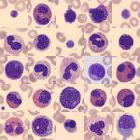

In [102]:

train_dataset.montage(length=5)

In [103]:
#Access a single image / label
image, label = train_dataset[2]  # image is a tensor , label is an  int
print("Shape da imagem:", image.shape)
print("Classe:", label)

# Convert to NumPy array
image_array = image.numpy()
print("Size:", image_array.shape )

#Access a subset of images
img = train_dataset[1][0].numpy   # image
lab = train_dataset[1][1]   # label
start_idx = 10
end_idx = 20  # exclusive
images_array = np.stack([train_dataset[i][0].numpy() for i in range(start_idx, end_idx)])
labels_array = np.array([train_dataset[i][1] for i in range(start_idx, end_idx)])

print("Size:", images_array.shape )
print(labels_array)




Shape da imagem: torch.Size([3, 28, 28])
Classe: [6]
Size: (3, 28, 28)
Size: (10, 3, 28, 28)
[[1]
 [1]
 [6]
 [7]
 [6]
 [3]
 [7]
 [2]
 [6]
 [1]]


## Flatten e Preparação dos dados
Aqui vamos transformar os dados em tipo numpy e dar flatten aos inputs como precisam de ser vetores 1D e não imagens

In [104]:
# Transformação dos datasets em inputs e outputs
x_train = train_dataset.imgs
y_train = train_dataset.labels
x_test = test_dataset.imgs
y_test = test_dataset.labels

# Converter para arrays NumPy (caso ainda sejam tensores)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


# Normalização para o cnn
x_train_cnn = x_train/255.0

x_test_cnn = x_test/255.0


# Flatten

x_train = x_train.reshape(x_train.shape[0], -1) 
x_test = x_test.reshape(x_test.shape[0], -1)

# Converter outra vez para tensors
x_train = torch.tensor(x_train).float()
x_train_cnn =  torch.tensor(x_train_cnn).float()

y_train = torch.tensor(y_train).long()

x_test = torch.tensor(x_test).float()
x_test_cnn =  torch.tensor(x_test_cnn).float()

y_test = torch.tensor(y_test).long()

#dados cnn

x_train_cnn = x_train_cnn.permute(0, 3, 1, 2)
x_test_cnn  = x_test_cnn.permute(0, 3, 1, 2)

num_inputs = x_train.shape[1]

### Normalização dos dados
 

In [105]:
# Normalização para a dnn

scaler = StandardScaler()
x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)

x_test = torch.tensor(scaler.fit_transform(x_test), dtype=torch.float32)


In [106]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### DNN

In [107]:
class DNN(nn.Module):
    def __init__(self, input_size , hidden_sizes, num_classes = n_classes):
        super(DNN, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        if len(hidden_sizes) == 0:
            self.layers.append(nn.Linear(input_size, num_classes))
        else:
            self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
            self.activations.append(nn.ReLU())        
        
            for i in range(len(hidden_sizes)-1):
                self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
                self.activations.append(nn.ReLU())

            self.layers.append(nn.Linear(hidden_sizes[-1], num_classes))
    
        # camada de saida softmax
        #self.output_activation = nn.Softmax(dim=1)

    def forward(self, x):
        out = x
        for i in range(len(self.layers)): # All layers
            out = self.layers[i](out) # out = W out
            if i < len(self.activations):
                out = self.activations[i](out) # out = activation(out)

        #out = self.output_activation(out)

        return out



In [ ]:
def fit(X_train, y_train, nn, criterion, optimizer, n_epochs, to_device=True, batch_size=BATCH_SIZE):
    #send everything to the device (ideally a GPU)
    
    y_train = y_train.squeeze()

    if to_device:
        nn = nn.to(device)
        X_train = X_train.to(device)
        y_train = y_train.to(device)

    # Train the network
    loss_values = []
    for epoch in range(n_epochs):
        nn.train()  # Ativa modo de treino
        
        accu_loss = 0
        for i in range(0, X_train.size(0), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            #y_batch = F.one_hot(y_batch,num_classes=n_classes).float() para one-hot encoding, para usar na MSELoss

            # Forward pass
            outputs = nn(X_batch)

            #print(outputs.shape)  # Deve ser [batch_size, n_classes]
            #print(y_batch.shape)  # Deve ser [batch_size]
            #print(y_batch.dtype)  # Deve ser torch.int64 (ou long)
            
            loss = criterion(outputs, y_batch)
            accu_loss += loss.item()
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, n_epochs, accu_loss))
        loss_values.append(accu_loss)

    return loss_values, nn.to("cpu")

In [ ]:
# Create the network, define criterion and optimizer
n_epochs = 15
n_layers = 1

# Determine the number of classes
hidden_layer_sizes = ((num_inputs + n_classes) // 2,)*n_layers
#print(hidden_layer_sizes)
dnn = DNN(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=n_classes)



#this criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class. 
#It expects the target to be class indices (not one-hot encoded)
criterion = nn.CrossEntropyLoss() 
#criterion = nn.MSELoss() 
optimizer = optim.SGD(dnn.parameters(), lr=0.1)
#optimizer = optim.Adam(dnn.parameters(), lr=0.001)

dnn_loss_values, dnn = fit(x_train, y_train, dnn, criterion, optimizer, n_epochs, batch_size=BATCH_SIZE, to_device=True)


Epoch [1/15], Loss: 72.3523
Epoch [2/15], Loss: 42.7375
Epoch [3/15], Loss: 31.5781
Epoch [4/15], Loss: 23.8197
Epoch [5/15], Loss: 17.7802
Epoch [6/15], Loss: 13.1297
Epoch [7/15], Loss: 9.5511
Epoch [8/15], Loss: 6.9350
Epoch [9/15], Loss: 5.0987
Epoch [10/15], Loss: 3.8297
Epoch [11/15], Loss: 2.9555
Epoch [12/15], Loss: 2.3529
Epoch [13/15], Loss: 1.9262
Epoch [14/15], Loss: 1.6150
Epoch [15/15], Loss: 1.3838


In [110]:

def evaluate_network(net, X, y, to_device=True):
    # Set the model to evaluation mode
    net.eval()
    if to_device:
        X = X.to(device)
        net = net.to(device)

    # Run the model on the test data
    with torch.no_grad():
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)

    # Convert tensors to numpy arrays
    if to_device:
        predicted = predicted.to("cpu")
    predicted_np = predicted.numpy()
    test_target_np = y.numpy()

    # Compute confusion matrix and F1 score
    conf_mat = confusion_matrix(test_target_np, predicted_np)
    f1 = f1_score(test_target_np, predicted_np, average='weighted')

    print('Confusion Matrix:\n', conf_mat)
    print('F1 Score: ', f1)
    
print('Evaluating with the training data')
evaluate_network(dnn, x_train, y_train)

print('Evaluating with the test data')
evaluate_network(dnn, x_test, y_test)


Evaluating with the training data
Confusion Matrix:
 [[ 852    0    0    0    0    0    0    0]
 [   0 2181    0    0    0    0    0    0]
 [   0    0 1085    0    0    0    0    0]
 [   1    0    0 2025    0    0    0    0]
 [   0    0    0    0  849    0    0    0]
 [   2    0    0    0    1  990    0    0]
 [   0    0    0    0    0    0 2330    0]
 [   0    0    0    0    0    0    0 1643]]
F1 Score:  0.9996655688418224
Evaluating with the test data
Confusion Matrix:
 [[176   2   0  39   9  16   2   0]
 [  0 604   0   6   2   0  12   0]
 [  1   1 268  14  10   5  10   2]
 [ 34  13   3 423  17  48  41   0]
 [  6   0  11  20 199   1   6   0]
 [  9   0   1  47   4 221   2   0]
 [  2  18   6  26   3   1 610   0]
 [  0   0   0   0   0   0   0 470]]
F1 Score:  0.8679904636696771


### CNN

In [111]:
# CNN


class CNN(nn.Module):
    def __init__(self, input_channels=3, num_classes = n_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        
        #8x8x8=512 is the dimension of the tensor after the last convolution. 
        #It consists of 8 filters of size 8x8 (due to pooling)
        # 8 hidden layers de fotos 7x7 (começam 28x28 -> 14x14 -> 7x7  por causa do max pooling)

        self.fc1 = nn.Linear(7*7*128, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x =  F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        #x = x.view(-1, self.fc1.in_features)
        x = x.reshape(-1, self.fc1.in_features)


        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:
n_epochs = 50
cnn = CNN(3)

#this criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class. 
#It expects the target to be class indices (not one-hot encoded)
criterion = nn.CrossEntropyLoss() 
#criterion = nn.MSELoss() 
optimizer = optim.Adam(cnn.parameters(), lr=0.001) #ESTÁVEL E RESULTADOS MELHORES
#optimizer = optim.SGD(cnn.parameters(), lr=0.1) #UM POUCO INSTÁVEL 

dnn_loss_values, cnn = fit(x_train_cnn, y_train, cnn, criterion, optimizer, n_epochs, batch_size=BATCH_SIZE, to_device=True)


Epoch [1/50], Loss: 119.9595
Epoch [2/50], Loss: 64.8290
Epoch [3/50], Loss: 53.0822
Epoch [4/50], Loss: 46.3621
Epoch [5/50], Loss: 41.4994
Epoch [6/50], Loss: 38.0474
Epoch [7/50], Loss: 35.8616
Epoch [8/50], Loss: 33.7236
Epoch [9/50], Loss: 31.4937
Epoch [10/50], Loss: 29.5356
Epoch [11/50], Loss: 27.7849
Epoch [12/50], Loss: 26.1747
Epoch [13/50], Loss: 24.7103
Epoch [14/50], Loss: 23.4791
Epoch [15/50], Loss: 22.2609
Epoch [16/50], Loss: 21.0788
Epoch [17/50], Loss: 20.6781
Epoch [18/50], Loss: 20.8759
Epoch [19/50], Loss: 19.4046
Epoch [20/50], Loss: 18.2603
Epoch [21/50], Loss: 17.2870
Epoch [22/50], Loss: 16.5963
Epoch [23/50], Loss: 15.7743
Epoch [24/50], Loss: 15.4082
Epoch [25/50], Loss: 15.2201
Epoch [26/50], Loss: 14.9780
Epoch [27/50], Loss: 13.9174
Epoch [28/50], Loss: 13.2060
Epoch [29/50], Loss: 12.5300
Epoch [30/50], Loss: 12.3967
Epoch [31/50], Loss: 11.4275
Epoch [32/50], Loss: 12.0827
Epoch [33/50], Loss: 11.8612
Epoch [34/50], Loss: 11.4553
Epoch [35/50], Loss: 1

In [113]:
print('Evaluating with the training data')
evaluate_network(cnn, x_train_cnn, y_train)

print('Evaluating with the test data')
evaluate_network(cnn, x_test_cnn, y_test)

Evaluating with the training data
Confusion Matrix:
 [[ 793    1    0    4   50    1    3    0]
 [   1 2132    0    5    0    0   43    0]
 [   1    0 1033    3   39    0    7    2]
 [  26    0    3 1642  125  106  124    0]
 [   0    0    0    0  849    0    0    0]
 [   2    0    0    7   21  957    6    0]
 [   0    0    0    0    0    0 2330    0]
 [   0    0    0    0    0    0    0 1643]]
F1 Score:  0.9513821442121873
Evaluating with the test data
Confusion Matrix:
 [[209   2   0  11  10   6   6   0]
 [  2 596   0   3   1   0  22   0]
 [  1   0 276  10  13   3   6   2]
 [ 17   5   9 402  37  61  48   0]
 [  0   0   2   3 238   0   0   0]
 [  4   0   1  15  14 247   3   0]
 [  1   3   2   3   3   1 653   0]
 [  0   0   0   0   0   0   1 469]]
F1 Score:  0.9017832137835486
